In [2]:
import numpy as np
from qibo import gates, hamiltonians, models
from scipy.optimize import minimize
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import argparse

In [13]:
def hamiltonian(nqubits):
        m0 = (1/nqubits)*hamiltonians.Z(nqubits, numpy=True).matrix
        ham = hamiltonians.Hamiltonian(nqubits, m0)
        return ham
    
def generator(params, x):
    circuit = models.Circuit(nqubits)
    circuit.add(gates.RY(0, params[0]*x + params[1]))
    circuit.add(gates.RY(1, params[2]*x + params[3]))
    circuit.add(gates.CZ(0, 1))
    circuit.add(gates.RY(0, params[4]*x + params[5]))
    circuit.add(gates.RY(1, params[6]*x + params[7]))
    circuit.add(gates.CZ(0, 1))
    circuit.add(gates.RY(0, params[8]*x + params[9]))
    circuit.add(gates.RY(1, params[10]*x + params[11]))
    return circuit
    
def cost_generator(params, opt_params_disc, samples, bins, count):
    cost = 0
    #run generator
    shots_fake = sample_generator(params, samples, bins)
    #run discriminator
    for i in range(len(mean_bins)):
        state = discriminator(opt_params_disc, mean_bins[i]).execute()
        probs = (1 - encoder.expectation(state).numpy().real)/2
        cost -= shots_fake[i]*probs
                
    if count[0] % 50 == 0:
        print(count[0], cost)
    count[0] += 1      
        
    return cost

def discriminator(params, x):
    circuit = models.Circuit(nqubits)
    circuit.add(gates.RY(0, params[0]*x + params[1]))
    circuit.add(gates.RY(1, params[2]*x + params[3]))
    circuit.add(gates.CZ(0, 1))
    circuit.add(gates.RY(0, params[4]*x + params[5]))
    circuit.add(gates.RY(1, params[6]*x + params[7]))
    circuit.add(gates.CZ(0, 1))
    circuit.add(gates.RY(0, params[8]*x + params[9]))
    circuit.add(gates.RY(1, params[10]*x + params[11]))
    circuit.add(gates.CZ(0, 1))
    circuit.add(gates.RY(0, params[12]*x + params[13]))
    circuit.add(gates.RY(1, params[14]*x + params[15]))
    return circuit
        
def cost_discriminator(params, opt_params_gen, shots_real, shots_fake, count):
    cost = 0
    for i in range(len(mean_bins)):
        #run real and fake data
        state = discriminator(params, mean_bins[i]).execute()
        probs = (1 - encoder.expectation(state).numpy().real)/2
        cost += (shots_fake[i]-shots_real[i])*probs
        
    if count[0] % 50 == 0:
        print(count[0], cost)
    count[0] += 1
        
    return cost

def sample_gaussian(mu, sigma, samples, bins):
    s = np.random.normal(mu, sigma, samples)
    count, bins = np.histogram(s, bins)
    return count

def sample_generator(params, samples, bins):
    fake_gaussian_sampling = []
    for i in range(samples):
        x = np.random.uniform(-1, 1)
        fake_sample = encoder.expectation(generator(params, x).execute()).numpy().real
        fake_gaussian_sampling.append(fake_sample)
    count, bins = np.histogram(fake_gaussian_sampling, bins)
    return count

In [3]:
nqubits = 2
encoder = hamiltonian(nqubits)
nparams_gen = 12
nparams_disc = 16
initial_params_disc = np.random.uniform(0, 2*np.pi, nparams_disc)
initial_params_gen = np.random.uniform(0, 2*np.pi, nparams_gen)

In [8]:
samples = 1000
bins = np.linspace(-1.0, 1.0, 11)
mean_bins = np.linspace(-0.95, 0.95, 10)
count_real = sample_gaussian(0, 0.25, samples, bins)
print(count_real)

[  0   8  39 158 299 289 150  46  10   0]


In [9]:
count_fake = sample_generator(initial_params_gen, samples, bins)
print(count_fake)

[  0   0   0 111 242 202 139 306   0   0]


In [10]:
count = [0]
print('\n Discriminator results: ')
result_disc = minimize(lambda p: cost_discriminator(p, initial_params_gen, count_real, count_fake, count), initial_params_disc,
                          method='Powell', options={'maxiter': 1e3, 'maxfev': 1e3})
print('Final parameters: ', result_disc.x)
print('Final cost function: ', result_disc.fun)

count = [0]
print('\n Generator results: ')
result_gen = minimize(lambda p: cost_generator(p, result_disc.x, samples, bins, count), initial_params_gen,
                          method='Powell', options={'maxiter': 30, 'maxfev': 30})
print('Final parameters: ', result_gen.x)
print('Final cost function: ', result_gen.fun)


 Discriminator results: 
0 -56.272943797984624
50 -164.56314142567513
100 -156.1564326015869
150 -175.51443282493796
200 -88.16459093239756
250 -185.16542580065484
300 -192.4812073281022
350 -213.42226701103192
400 -5.079097692571491
450 -221.5196766497925
500 -222.73509163982067
550 -223.01888604919608
600 -221.0393282429484
650 -202.47107585012333
700 -82.21327449665952
750 -232.2945825775905
800 -99.61913016667275
850 -233.97145312661485
900 -209.3100626163929
950 -232.84566757770884
1000 -239.27570661608428
1050 -240.19498583860246
1100 -240.96360871873944
Final parameters:  [ 3.6391309   2.82882693 -1.15539782 -1.08997926  3.62803488  3.581753
  1.19366673  3.39780738  3.65255855  2.39385654  4.49349973 -0.89002603
  0.2689356   2.45892733  5.65801694  3.47814239]
Final cost function:  -241.05220860032503

 Generator results: 
0 -630.9679331629943
1 -652.4897957865852
2 -757.9874078814219
3 -709.9802129846812
4 -765.3054108577288
5 -738.9631883027457
6 -750.355974311721
7 -784.37

In [11]:
count_fake = sample_generator(result_gen.x, samples, bins)
print(count_fake)

[  0   7 174 210 254 336  19   0   0   0]


In [12]:
for i in range(5):
    count = [0]
    print('\n Discriminator results: ')
    result_disc = minimize(lambda p: cost_discriminator(p, result_gen.x, count_real, count_fake, count), result_disc.x,
                              method='Powell', options={'maxiter': 1e3, 'maxfev': 1e3})
    print('Final parameters: ', result_disc.x)
    print('Final cost function: ', result_disc.fun)
    
    count = [0]
    print('\n Generator results: ')
    result_gen = minimize(lambda p: cost_generator(p, result_disc.x, samples, bins, count), result_gen.x,
                              method='Powell', options={'maxiter': 30, 'maxfev': 30})
    print('Final parameters: ', result_gen.x)
    print('Final cost function: ', result_gen.fun)
    
    count_fake = sample_generator(result_gen.x, samples, bins)
    print(count_fake)


 Discriminator results: 
0 95.02707632656151
50 -120.49582979347005
100 -139.49708156346233
150 -59.98136196049437
200 -147.48424436048737
250 -154.8544570957366
300 -128.7554396873914
350 -172.3511861312131
400 -173.87919846875096
450 -176.47936747262682
500 -179.11319049340014
550 -180.18543986773716
600 -101.65126770509727
650 -118.86190195862203
700 -176.70717632858873
750 -187.83071451583655
800 -184.34936996812618
850 -180.87702494518982
900 -191.55018976552566
950 -194.06652070747103
1000 -201.4261811031141
1050 -47.400280832600245
1100 -186.74075408785112
Final parameters:  [ -4.19108019   3.04513504 100.97567262  -2.08935847   2.27220488
   2.80890217   0.75186409   3.65501133   2.71152384   2.39189552
   7.04482029  -0.67714902  -0.55142551   1.74096017   9.66462913
   3.34854015]
Final cost function:  -206.3818879884353

 Generator results: 
0 -379.2602738019221
1 -382.076655358972
2 -375.0677337426365
3 -583.2270222258088
4 -443.6913708600702
5 -567.6462579824479
6 -533.32

85 -719.0263168610443
86 -702.7394487094442
87 -677.3830349424654
88 -694.0513452580087
89 -714.9774375630028
90 -690.3807226911656
91 -691.8423795007338
92 -692.8294633927011
93 -716.1074307797478
94 -710.843976576534
95 -806.3919253097444
96 -443.7762711547936
97 -797.5928657948252
98 -703.6927725523739
99 -773.5578115508134
100 -817.9912010612618
101 -806.7554815904292
102 -820.5625324363289
103 -808.7079696642392
104 -829.8152642039397
105 -817.3965514427995
106 -818.7217906072719
107 -816.7439623908741
108 -814.3945965809265
109 -789.2616562966504
110 -544.2389309005854
111 -816.7860456417444
112 -770.2900255509751
113 -830.9481222098668
114 -811.5953068126458
115 -832.6725431780886
116 -832.1992130716752
117 -831.9822470287289
118 -819.1715528664821
119 -824.3188517688569
120 -824.8357553322343
121 -537.4332772272838
122 -555.0033344659174
123 -821.6355963857307
124 -816.0148776416071
125 -761.292982594496
126 -824.2240107593152
127 -824.9196358083718
128 -825.7428996535024
129 -

160 -758.5642241363277
161 -757.7513563498692
162 -784.7335874702411
163 -754.7985237663007
164 -778.4265291390694
165 -757.3098570981563
166 -778.2950691774573
167 -764.5107443342431
168 -768.1649249720483
169 -624.4585503028188
170 -778.0711648432324
171 -790.6824552721914
172 -768.0872408514041
173 -796.6191503152626
174 -804.7054125811391
175 -813.9909029979326
176 -797.3523857422235
177 -794.0562646803733
178 -784.3483913130655
179 -798.7892130289031
180 -803.6021635365207
181 -802.5648779616023
Final parameters:  [10.5538534   3.99960777  5.80006131  5.28037104  4.58977031  5.75014924
  7.03697151  3.09855917  0.05319736  0.60998072  4.67558585  3.84830331]
Final cost function:  -813.9909029979326
[  0   0   0  60 353 245 136 138  38  30]

 Discriminator results: 
0 91.2709409013364
50 -64.84375114128696
100 -116.6462084610126
150 14.257699032577587
200 -33.62083406385527
250 -154.74969970393397
300 -159.90315379699965
350 -43.821607596305924
400 -167.58449672462774
450 -169.5571

68 -756.6311166020589
69 -720.9739565159738
70 -721.7768067999792
71 -727.4164007286253
72 -739.9568829221496
73 -637.7153836767129
74 -704.0196185592589
75 -706.2672552974532
76 -679.0975886822956
77 -717.7759871952817
78 -645.1697654735053
79 -713.0311214676286
80 -662.6304391581107
81 -713.7623886962675
82 -685.927999834639
83 -745.067883317698
84 -721.0263496211325
85 -717.4256017505735
86 -735.464965731098
87 -736.0280993938725
88 -536.1630686800053
89 -703.6295404966676
90 -731.4736418450168
91 -688.0055929367094
92 -618.0802278398954
93 -709.5720699185911
94 -692.1815955370009
95 -722.2078738196841
96 -698.3220495459
97 -743.5533178151258
98 -733.2984240936067
99 -704.133194876335
100 -708.1360207734843
101 -736.7854591035621
102 -714.0968060037202
103 -706.1948791013174
104 -734.9074362841336
105 -732.283077980863
106 -635.712791016933
107 -664.3932288642159
108 -713.7790795117803
109 -543.5063408761027
110 -730.0440014507144
111 -724.4928924813659
112 -678.4869566450382
113 -6

In [14]:
for i in range(5):
    count = [0]
    print('\n Discriminator results: ')
    result_disc = minimize(lambda p: cost_discriminator(p, result_gen.x, count_real, count_fake, count), result_disc.x,
                              method='Powell', options={'maxiter': 1e3, 'maxfev': 1e3})
    print('Final parameters: ', result_disc.x)
    print('Final cost function: ', result_disc.fun)
    
    count = [0]
    print('\n Generator results: ')
    result_gen = minimize(lambda p: cost_generator(p, result_disc.x, samples, bins, count), result_gen.x,
                              method='Powell', options={'maxiter': 30, 'maxfev': 30})
    print('Final parameters: ', result_gen.x)
    print('Final cost function: ', result_gen.fun)
    
    count_fake = sample_generator(result_gen.x, samples, bins)
    print(count_fake)


 Discriminator results: 
0 23.26444318785294
50 -130.24446252264661
100 -145.2646306217858
150 -169.98022019081205
200 -184.22357991270084
250 -193.6436475899587
300 -201.51197267402657
350 -152.7595127346656
400 -195.85751069850136
450 -208.13821819456714
500 -208.23652778429016
550 -208.71388884901262
600 -208.82899009209513
650 -208.8850115226777
700 -208.97668324147426
750 -208.99477482584706
800 -209.1012309072831
850 -209.13213201077065
900 -209.149409937082
950 -209.1629684018054
1000 -209.17987207937168
1050 -209.18391571605076
1100 -209.19025494709837
Final parameters:  [14.98326649  3.51307089 88.63336373 -1.36993063 13.10925212  0.9257744
 -5.57253332  3.83836343  2.66063514  0.37924694  8.67839613 -1.99294704
  6.38881716  0.36057875 12.52896746  4.27057094]
Final cost function:  -209.1924955459703

 Generator results: 
0 -536.3827188886875
50 -709.4027253776711
100 -623.488097630379
150 -694.258767150985
200 -677.9867252289131
Final parameters:  [21.09666661  3.59309443  

In [15]:
for i in range(10):
    count = [0]
    print('\n Discriminator results: ')
    result_disc = minimize(lambda p: cost_discriminator(p, result_gen.x, count_real, count_fake, count), result_disc.x,
                              method='Powell', options={'maxiter': 1e3, 'maxfev': 1e3})
    print('Final parameters: ', result_disc.x)
    print('Final cost function: ', result_disc.fun)
    
    count = [0]
    print('\n Generator results: ')
    result_gen = minimize(lambda p: cost_generator(p, result_disc.x, samples, bins, count), result_gen.x,
                              method='Powell', options={'maxiter': 30, 'maxfev': 30})
    print('Final parameters: ', result_gen.x)
    print('Final cost function: ', result_gen.fun)
    
    count_fake = sample_generator(result_gen.x, samples, bins)
    print(count_fake)


 Discriminator results: 
0 -158.4982751849323
50 -145.7099779144527
100 -163.70899365831002
150 -165.78124623296458
200 -168.80002575394198
250 -163.26272192058062
300 -173.98959107451483
350 -181.52061754361645
400 -182.98263618275053
450 -184.26503457265912
500 -42.90934728321169
550 -172.01622622141636
600 -187.11179308274302
650 -175.17022646976258
700 -190.73459948118096
750 -180.4287525079924
800 -189.25372893094467
850 -195.4869503093854
900 -197.37364694148647
950 -199.76052345841788
1000 -174.60360396170643
1050 -203.4668753845842
1100 -206.72730252707976
Final parameters:  [20.30902322 -0.33344527 82.24428539  4.78505106 15.44051429 -0.10336381
 -0.91783387  2.54124124  1.30186536 -0.56254404 15.00192146 -0.74999689
  6.75711511  1.3939793  14.85200818  3.77097632]
Final cost function:  -209.3633879394839

 Generator results: 
0 -624.7208162904857
50 -604.626777433165
100 -711.6220399297061
150 -687.6556556606191
Final parameters:  [31.46487946  4.44242722  7.35641597  5.456

150 -755.6754841306366
200 -744.8762422495822
Final parameters:  [35.8524411   8.67985923  9.00856995  5.34241945  4.91954881  8.00844454
  5.366659    6.49881713 -0.46246818  0.06538741  3.66457621  7.99833308]
Final cost function:  -770.2125109499095
[ 33  11  10  63 229 447  63  59  44  41]

 Discriminator results: 
0 -31.62736301753953
50 -42.76207592185955
100 -41.17409465506567
150 -18.730152241792865
200 -109.48821024675327
250 -132.66364026241612
300 -146.57507841415446
350 -145.2228938437832
400 -89.63240192481588
450 -172.22810113356826
500 -191.3521658043229
550 -170.26397308872342
600 -202.14950858115665
650 -206.66618518930184
700 -195.22486077080927
750 -211.44436688305697
800 -210.5186455833641
850 -209.43716848172295
900 -218.7275150940162
950 -220.56067160181755
1000 -234.26135418765585
1050 -235.71428993995218
1100 -236.6954632144268
Final parameters:  [14.26996342  0.71957871 82.39698761  4.05056159 11.2913347  -2.8401226
 -2.72679539  3.61828425 10.14355442 -0.53295

In [16]:
for i in range(10):
    count = [0]
    print('\n Discriminator results: ')
    result_disc = minimize(lambda p: cost_discriminator(p, result_gen.x, count_real, count_fake, count), result_disc.x,
                              method='Powell', options={'maxiter': 1e3, 'maxfev': 1e3})
    print('Final parameters: ', result_disc.x)
    print('Final cost function: ', result_disc.fun)
    
    count = [0]
    print('\n Generator results: ')
    result_gen = minimize(lambda p: cost_generator(p, result_disc.x, samples, bins, count), result_gen.x,
                              method='Powell', options={'maxiter': 30, 'maxfev': 30})
    print('Final parameters: ', result_gen.x)
    print('Final cost function: ', result_gen.fun)
    
    count_fake = sample_generator(result_gen.x, samples, bins)
    print(count_fake)


 Discriminator results: 
0 54.93865514001668
50 -99.26926531896918
100 -121.44724576010258
150 -134.3870628719084
200 -181.6710880167004
250 -190.78874974751352
300 -203.69383982459163
350 -200.27671243477624
400 -204.7533818995399
450 -212.3072505072799
500 -213.68967711769955
550 -214.5607912567371
600 -217.3796123682703
650 -197.09178138017546
700 -90.79193423985075
750 -222.40055297867667
800 -44.67314965449995
850 -183.25325050254773
900 -222.7489663225463
950 -223.4759433357945
1000 -204.80016864487533
1050 -108.98183426615215
1100 -192.10230469368366
Final parameters:  [ 2.15023252e+01  8.83356180e+00  8.44775046e+01  5.01295823e+00
  1.31391041e+01 -3.55464749e+00 -5.17642413e+00  2.87594157e+00
  8.92145137e+00 -1.61440067e-02  1.12023205e+01 -3.75203979e+00
  3.95191120e+00  1.34721869e+00  1.26965164e+01  6.49946400e+00]
Final cost function:  -223.80245611616357

 Generator results: 
0 -578.0128314831027
50 -735.188123855114
100 -772.0494154020728
150 -793.3681575883685
200

[ 20  27  29 151 302 229 109  72  32  29]

 Discriminator results: 
0 -46.068650795567635
50 -71.99312920747056
100 -73.73484599910712
150 -82.71775031922112
200 -87.53120453975558
250 -82.27052636932207
300 -91.37512972889571
350 -90.11839449796804
400 -90.03331151687735
450 -92.6560385078174
500 -99.22117265495494
550 -93.91615139981798
600 -100.19124108427634
650 -89.09793239489353
700 -96.74737009395899
750 -83.78276364813938
800 -100.75802033118805
850 -75.86295070638596
900 -25.043470958453703
950 -49.496496349680584
1000 -64.58289397538913
1050 -95.23659443090453
1100 -77.85460418069704
Final parameters:  [37.95350309  8.86444017 70.36113151  3.49866264 15.53701227 -2.56398841
 -2.91766987  2.56028873 -1.46793718 -0.96416528 14.25345903 -2.27732593
 11.34934353  0.78103917 10.86271903  4.76848171]
Final cost function:  -101.20187457370366

 Generator results: 
0 -627.7744271545155
50 -625.8601203866207
100 -625.767972892557
150 -664.9164014624101
200 -670.1066512161299
Final par

In [17]:
for i in range(5):
    count = [0]
    print('\n Discriminator results: ')
    result_disc = minimize(lambda p: cost_discriminator(p, result_gen.x, count_real, count_fake, count), result_disc.x,
                              method='Powell', options={'maxiter': 1e3, 'maxfev': 1e3})
    print('Final parameters: ', result_disc.x)
    print('Final cost function: ', result_disc.fun)
    
    count = [0]
    print('\n Generator results: ')
    result_gen = minimize(lambda p: cost_generator(p, result_disc.x, samples, bins, count), result_gen.x,
                              method='Powell', options={'maxiter': 30, 'maxfev': 30})
    print('Final parameters: ', result_gen.x)
    print('Final cost function: ', result_gen.fun)
    
    count_fake = sample_generator(result_gen.x, samples, bins)
    print(count_fake)


 Discriminator results: 
0 -92.82209025971486
50 -44.37210405888962
100 -90.82546476306125
150 -101.16573975216454
200 -74.02882525866073
250 -103.3280956127495
300 -102.57322252242315
350 -105.32911599317968
400 -105.60037861449457
450 -106.02768072399459
500 -106.22522998862539
550 -106.29070503479366
600 -106.44677724747464
650 -106.48080189390275
700 -106.50440910022125
750 -106.56720420322887
800 -106.57170955524137
850 -106.57786100294803
900 -106.60358153462738
950 -106.62176092901733
1000 -106.62897767417891
1050 -106.63171131414433
1100 -105.59077772003276
Final parameters:  [39.21585096 10.15394536 70.19676093  2.80179484 16.45406195 -3.25124586
 -2.37009721  2.55417489 -1.19034538 -0.56313905 14.94352958 -1.76250017
 12.39076532  2.3658625  11.21683715  5.87072768]
Final cost function:  -106.63504736097221

 Generator results: 
0 -701.176437106036
50 -717.711765010911
100 -748.4910260545915
150 -740.2474513166128
Final parameters:  [62.96755713 24.31931818 -0.36646762  5.90

In [18]:
for i in range(5):
    count = [0]
    print('\n Discriminator results: ')
    result_disc = minimize(lambda p: cost_discriminator(p, result_gen.x, count_real, count_fake, count), result_disc.x,
                              method='Powell', options={'maxiter': 1e3, 'maxfev': 1e3})
    print('Final parameters: ', result_disc.x)
    print('Final cost function: ', result_disc.fun)
    
    count = [0]
    print('\n Generator results: ')
    result_gen = minimize(lambda p: cost_generator(p, result_disc.x, samples, bins, count), result_gen.x,
                              method='Powell', options={'maxiter': 30, 'maxfev': 30})
    print('Final parameters: ', result_gen.x)
    print('Final cost function: ', result_gen.fun)
    
    count_fake = sample_generator(result_gen.x, samples, bins)
    print(count_fake)


 Discriminator results: 
0 131.33266450812982
50 -92.99257893856193
100 -149.3387378229374
150 -150.4934488305136
200 -167.93911020328838
250 -169.32687238417964
300 -190.75141078903323
350 -188.45567745194043
400 -195.64726084984972
450 -192.33116635349367
500 -204.8181864831302
550 -206.49318723874026
600 -163.5071304598945
650 -211.85903192839808
700 -201.5928169328984
750 -214.9804229149067
800 -221.09891310975803
850 -222.1890905032697
900 -223.59024715408336
950 -223.94937041006762
1000 -224.80571777909446
1050 -225.81095391876045
1100 -226.20342677478388
Final parameters:  [50.41354785 12.72805974 69.12291391  1.69215672 22.80378491 -1.63043744
 -4.06481562  0.26968199 -4.60850184 -1.11301636  8.39272567 -1.05456455
 12.82346806  1.49740338 10.30241165  7.78763472]
Final cost function:  -226.20351493465293

 Generator results: 
0 -269.0794857235271
50 -502.7655284745174
100 -555.4581812123569
150 -601.9298286443105
Final parameters:  [67.25877338 33.55792343  1.14203363  8.3944

In [19]:
for i in range(10):
    count = [0]
    print('\n Discriminator results: ')
    result_disc = minimize(lambda p: cost_discriminator(p, result_gen.x, count_real, count_fake, count), result_disc.x,
                              method='Powell', options={'maxiter': 1e3, 'maxfev': 1e3})
    print('Final parameters: ', result_disc.x)
    print('Final cost function: ', result_disc.fun)
    
    count = [0]
    print('\n Generator results: ')
    result_gen = minimize(lambda p: cost_generator(p, result_disc.x, samples, bins, count), result_gen.x,
                              method='Powell', options={'maxiter': 30, 'maxfev': 30})
    print('Final parameters: ', result_gen.x)
    print('Final cost function: ', result_gen.fun)
    
    count_fake = sample_generator(result_gen.x, samples, bins)
    print(count_fake)


 Discriminator results: 
0 -31.95010845773034
50 -10.859029374373776
100 -61.99217100643166
150 -98.36261033638333
200 -114.64578653612567
250 -121.32859454629802
300 -129.1890883347854
350 -130.84548619009433
400 -134.67570229111968
450 -136.054782030789
500 -112.0218029920943
550 -138.28530047873167
600 -134.26680937941978
650 -140.69346393442703
700 -140.98461881468756
750 -141.20949049200357
800 -141.30704593022386
850 -141.36637168154368
900 -141.5397715881855
950 -142.3009778320035
1000 -142.93015134838623
1050 -143.5551891177911
1100 -143.9811955423855
Final parameters:  [56.91534602 11.27302683 70.8820103   0.99836549 21.89030208 -2.49057128
 -5.65692208  0.09597666 -5.53550387 -1.5270696   7.99928672 -0.26241757
 12.78447379  1.74955892 12.52992704  8.16323775]
Final cost function:  -144.34580672142218

 Generator results: 
0 -653.8034711477699
50 -650.7853745177264
100 -697.4889208758567
150 -704.5173029288862
Final parameters:  [ 71.18589027  36.95680262 -10.93046257  11.07

0 -718.3681977320477
50 -736.0765847181093
100 -732.2167668797372
150 -755.517746907172
200 -749.9060208686543
Final parameters:  [  71.38054995 -120.58445272   -3.35215921   10.30305947   20.03273179
    8.66317019    6.00621108   11.95059852   -1.29067264    2.65379971
    1.75231635    5.92774911]
Final cost function:  -725.0653703969925
[  0  12  57  74 234 297 141  89  74  22]

 Discriminator results: 
0 -127.91087692236995
50 -133.52085774364684
100 -130.84354679094002
150 -138.8490932583573
200 -140.67826209296845
250 -141.03540349928247
300 -104.18549943900625
350 -143.55746925112234
400 -122.78119581350414
450 -140.9481254981434
500 -146.42746565206704
550 -146.6532524413469
600 -146.87364633426972
650 -147.18071871225544
700 -147.32043447779583
750 -147.54403868686975
800 -148.2548922213029
850 -106.23538721668079
900 -116.34982483857732
950 -148.61586400893458
1000 -134.71138758863856
1050 -33.071287643100874
1100 -148.65904612906215
Final parameters:  [57.9073382  12.157663

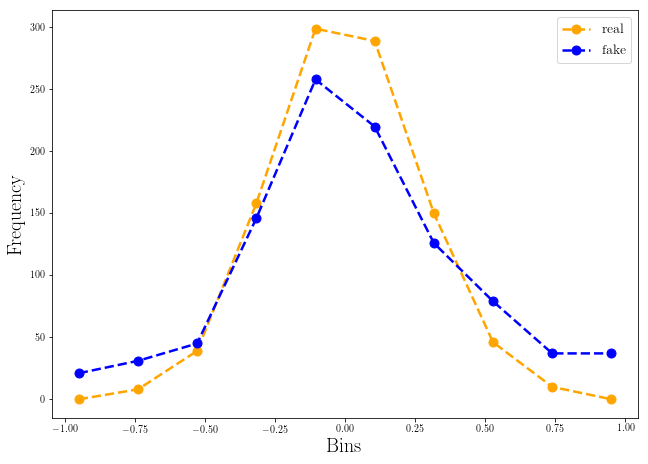

In [11]:
fig = plt.figure(figsize=[10.5, 7.5])

real = [  0,   8,  39, 158, 299, 289, 150,  46,  10,   0]
fake = [ 21,  31,  45, 146, 258, 220, 126,  79,  37,  37]
fake2 = [ 0,  12,  57,  74, 234, 297, 141,  89,  74,  22]
fake3 = [ 21,  31,  45, 146, 258, 220, 126,  79,  37,  37]
bins_mean = np.linspace(-0.95, 0.95, 10)


# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Bins', fontsize=20)
plt.plot(bins_mean, real, linewidth=2.5, color="orange", marker='o', markersize=9, linestyle='dashed', label ='real')
plt.plot(bins_mean, fake3, linewidth=2.5, color="blue", marker='o', markersize=9, linestyle='dashed', label ='fake')
plt.legend(loc=1, prop={'size': 14})